In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [18]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import yaml, os

In [3]:
omp = 1
mpi = 4

In [4]:
code = C.QeCalculator(omp=omp,mpi=mpi,verbose=False)
#code = C.QeCalculator(omp=omp,mpi=mpi,scheduler='slurm',sbatch_options=['--partition=all12h'])
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler direct


{'omp': 1,
 'mpi': 4,
 'mpi_run': 'mpirun -np',
 'executable': 'pw.x',
 'scheduler': 'direct',
 'skip': True,
 'clean_restart': True,
 'verbose': False}

# DFT analysis of GaAs

This notebook contains the analysis of the GaAs performed with QuantumESPRESSO for the construction
of the band structure used in the TD analysis.

## GS convergence

The perform again the procedure for the GS convergence. This procedure seek the convergence for the energy cutoff
of the wavefunctions and for the number of k points for the consturction of the density. The total gs energy is the control
parameter. When convergence is reached we computed the lattice equilibrium distance.

In [5]:
run_dir = 'GS'

We define the parameters for the convergence procedure

In [6]:
energy_0 = 80 # in compliance with the prescription of the pseudo
energy_step = 10
energy_max = 120
num_energies = int((energy_max-energy_0)/energy_step) + 1
energies = np.linspace(energy_0,energy_max,num=num_energies)

kpoint_0 = 4 # number kpoints used for the energy cutoff convergence
kpoint_step = 1
kpoint_max = 8
kpoints = [[k,k,k] for k in range(kpoint_0,kpoint_max+1,kpoint_step)]

alat_0 = 10.5 # guess used for the gs convergence
alat_delta = 0.2 # spread aroung alat_0
num_alat = 5
alat_deltas = np.linspace(-alat_delta/2,alat_delta/2,num=num_alat)

energy_rtol = 1e-5
kpoint_rtol = 1e-4

We build the basic element of the input object for the gs convergence

In [7]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=alat_0) 
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_rel.pz-rrkj3.UPF')
inp.add_atom('As','As_rel.pz-rrkj3.UPF')
inp.set_atoms_number(2)
inp.set_spinorbit()
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
#inp

### Convergence of the energy cutoff 

In [8]:
study = D.Dataset(run_dir=run_dir,label='energy-cutoff',num_tasks=1,verbose=False)
study.set_postprocessing_function(D.PostProcessing.QE_get_energy)

Initialize a Dataset with 1 parallel tasks


In [9]:
inp.set_kpoints(points=kpoints[0])
for e in energies:
    id = dict(energy_cutoff=e)
    inp.set_energy_cutoff(e)
    inp.set_prefix(D.name_from_id(id))
    study.append_run(id=id,input=inp,runner=code)

Seeking convergence for id " {'energy_cutoff': 80.0} "
Convergence reached in Dataset "energy-cutoff" for id " {'energy_cutoff': 80.0} "


/home/marco/Applications/MPPI/mppi/Datasets/Dataset.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(iruns, rotation=45)


{'id_conv': {'energy_cutoff': 80.0}, 'value_conv': -8.657633060028276}

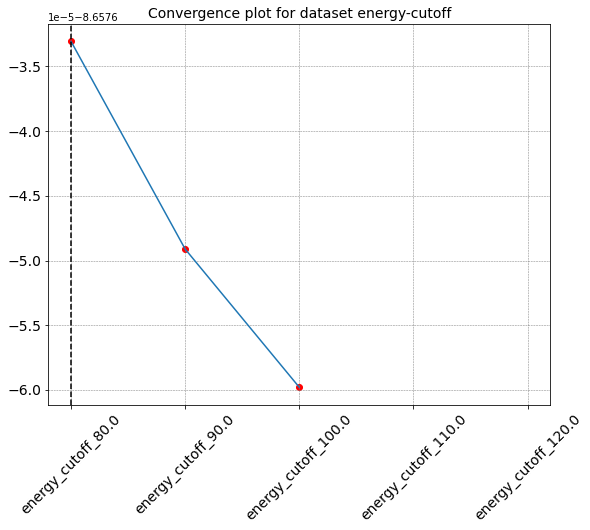

In [10]:
energy_converged = study.seek_convergence(rtol=energy_rtol,convergence_level=2)
energy_converged

In [11]:
inp.set_energy_cutoff(energy_converged['id_conv']['energy_cutoff'])

### Convergence of the number of kpoints

In [12]:
study = D.Dataset(run_dir=run_dir,label='kpoints-cutoff',num_tasks=1,verbose=False)
study.set_postprocessing_function(D.PostProcessing.QE_get_energy)

Initialize a Dataset with 1 parallel tasks


In [13]:
for k in kpoints:
    id = dict(kpoints=k[0])
    inp.set_kpoints(points=k)
    inp.set_prefix(D.name_from_id(id))
    study.append_run(id=id,input=inp,runner=code)

Seeking convergence for id " {'kpoints': 4} "
Seeking convergence for id " {'kpoints': 5} "
Seeking convergence for id " {'kpoints': 6} "
Convergence reached in Dataset "kpoints-cutoff" for id " {'kpoints': 6} "


{'id_conv': {'kpoints': 6}, 'value_conv': -8.663703989104807}

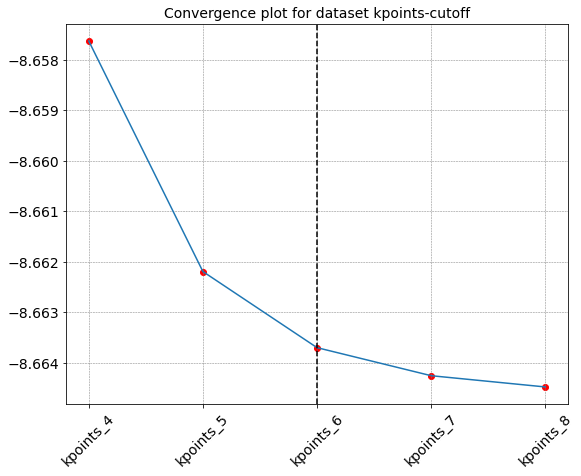

In [14]:
kpoints_converged = study.seek_convergence(rtol=kpoint_rtol,convergence_level=2)
kpoints_converged

In [15]:
kpoint_conv = kpoints_converged['id_conv']['kpoints']
inp.set_kpoints(points=[kpoint_conv,kpoint_conv,kpoint_conv])

### Computation of the equilibrium lattice constant

In [16]:
study = D.Dataset(run_dir=run_dir,label='lattice-constants',num_tasks=2,verbose=True)
study.set_postprocessing_function(D.PostProcessing.QE_get_energy)

Initialize a Dataset with 2 parallel tasks


In [18]:
for d in alat_deltas:
    d = np.around(d,decimals=2)
    id = dict(delta=d)
    inp.set_lattice(2,celldm1=alat_0+d)
    inp.set_prefix(D.name_from_id(id))
    study.append_run(id=id,input=inp,runner=code)

In [19]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
run command: cd GS; mpirun -np 4 pw.x -inp delta_-0.1.in > delta_-0.1.log
run command: cd GS; mpirun -np 4 pw.x -inp delta_-0.05.in > delta_-0.05.log
computation delta_-0.1 is running...
computation delta_-0.05 is running...
computation delta_-0.1 ended
computation delta_-0.05 ended
Task [0, 1] ended 

Run the task [2, 3] 
run command: cd GS; mpirun -np 4 pw.x -inp delta_0.0.in > delta_0.0.log
run command: cd GS; mpirun -np 4 pw.x -inp delta_0.05.in > delta_0.05.log
computation delta_0.0 is running...
computation delta_0.05 is running...
computation delta_0.05 ended
computation delta_0.0 ended
Task [2, 3] ended 

Run the task [4] 
run command: cd GS; mpirun -np 4 pw.x -inp delta_0.1.in > delta_0.1.log
computation delta_0.1 is running...
computation delta_0.1 ended
Task [4] ended 



We perform a quadratic fit of data

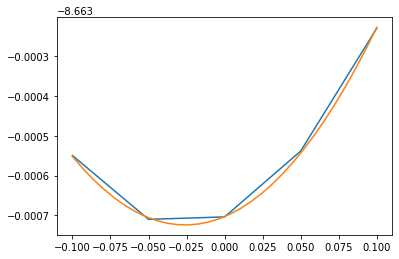

In [20]:
res = [results[i] for i in range(len(alat_deltas))]
coeffs = np.polyfit(alat_deltas,res,2)
values_fit = np.linspace(alat_deltas[0],alat_deltas[-1],30)
res_fit = [coeffs[0]*x**2+coeffs[1]*x+coeffs[2] for x in values_fit]
plt.plot(alat_deltas,res)
plt.plot(values_fit,res_fit)

In [22]:
delta_eq = -coeffs[1]/(2*coeffs[0])
alat_eq = np.around(alat_0+delta_eq,decimals=3)
alat_eq

10.474

We perform a last scf computation with converged parameters

In [23]:
conv_name = 'gs_converged'
inp.set_lattice(2,celldm1=alat_eq)
inp.set_prefix(conv_name)

In [24]:
code.run(input=inp,name=conv_name,run_dir=run_dir,verbose=True)

run command: cd GS; mpirun -np 4 pw.x -inp gs_converged.in > gs_converged.log
computation gs_converged is running...
computation gs_converged ended


'GS/gs_converged.save/data-file-schema.xml'

## NSCF computation on various grids

We perform nscf computations on grids of various dimensions and type. These computations will be the starting points for various
RT analysis, to the effects of the kpoints sampling in the real-time reponse of the systems. 

All the computations share the same scf input. The common parameters are

In [56]:
run_dir = 'NSCF'
source_dir = 'GS/gs_converged.save'
source_input = 'GS/gs_converged.in'
num_bands = 12 # we include 4 empty bands

In [57]:
inp = I.PwInput(file=source_input)
inp.set_nscf(num_bands,force_symmorphic=True,conv_thr=1e-6)

We build the lists of k points for the various cases

In [216]:
import random as rand

In [269]:
k_high_freq = [-0.0247738, 0.00762269, 0.02365302] # kpoints with high freq cc' oscillations of period 4.38 ps
gamma = [0.,0.,0.]
weight = [1.]

In [270]:
# generate the random list
num_kpoints = 100
k_span = 0.05

klist = []
klist.append(gamma+weight) #we include Gamma
klist.append(k_high_freq+weight) #we include the kpoints with high freq cc' oscillations
for n in range(num_kpoints-2):
    k_rand = [k_span*(rand.random()-0.5) for ind in range(3)] + weight
    klist.append(k_rand)

In [271]:
# write the list of random kpoints to file
k_dict = {'kpoints': klist}
if not os.path.isdir(run_dir):
    os.makedirs(run_dir)
filename = os.path.join(run_dir,'klist_'+str(num_kpoints)+'-kspan_'+str(k_span)+'.yaml')
print('written to :',filename)
with open(filename, 'w') as yaml_file:    
    yaml.dump(k_dict, yaml_file, default_flow_style=True)

written to : NSCF/klist_100-kspan_0.05.yaml


In [272]:
# read the list of random kpoint from file
filename = 'NSCF/klist_100-kspan_0.05.yaml'
klist_100_005 = yaml.load(open(filename), Loader=yaml.FullLoader)['kpoints']

In [273]:
study = D.Dataset(run_dir=run_dir,label='nscf',num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.QE_parse_data)

Initialize a Dataset with 1 parallel tasks


In [274]:
## regular grid
num_k = 8
idd = {'sampling' : 'regular', 'num_k' : num_k}
pref = D.name_from_id(idd)
inp.set_kpoints(type='automatic',points=[num_k,num_k,num_k])
inp.set_prefix(pref)
study.append_run(input=inp,id=idd,runner=code,source_dir=source_dir)

## gamma
idd = {'sampling' : 'gamma'}
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=[gamma+weight])
inp.set_prefix(pref)
study.append_run(input=inp,id=idd,runner=code,source_dir=source_dir)

## single k points with high freq oscillations in the cc' sector
idd = {'sampling' : '1k-maxfreq'}    
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=[k_high_freq+weight])
inp.set_prefix(pref)
study.append_run(input=inp,id=idd,runner=code,source_dir=source_dir)

## random 100 kpoints kspan=0.05
idd = {'num_k' : 100, 'sampling' : 'random_kspan0.05'}  
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist_100_005)
inp.set_prefix(pref)
study.append_run(input=inp,id=idd,runner=code,source_dir=source_dir,skip=False)

In [275]:
results = study.run()
results

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0], [1], [2], [3]] 

Run the task [0] 
The folder NSCF/num_k_8-sampling_regular.save already exsists. Source folder GS/gs_converged.save not copied
Skip the run of num_k_8-sampling_regular
Task [0] ended 

Run the task [1] 
The folder NSCF/sampling_gamma.save already exsists. Source folder GS/gs_converged.save not copied
Skip the run of sampling_gamma
Task [1] ended 

Run the task [2] 
The folder NSCF/sampling_1k-maxfreq.save already exsists. Source folder GS/gs_converged.save not copied
Skip the run of sampling_1k-maxfreq
Task [2] ended 

Run the task [3] 
delete log file: NSCF/num_k_100-sampling_random_kspan0.05.log
delete xml file: NSCF/num_k_100-sampling_random_kspan0.05.xml
delete folder: NSCF/num_k_100-sampling_random_kspan0.05.save
Copy source_dir GS/gs_converged.save in the NSCF/num_k_100-sampling_random_kspan0.05.save
run command: cd NSCF; mpirun -np 4 pw.x -inp num_k_100-sampling_random_kspan0.05.in > num_k_100-sa

{0: <mppi.Parsers.PwParser.PwParser at 0x7fd30dd6a3d0>,
 1: <mppi.Parsers.PwParser.PwParser at 0x7fd30de152b0>,
 2: <mppi.Parsers.PwParser.PwParser at 0x7fd30e71dfa0>,
 3: <mppi.Parsers.PwParser.PwParser at 0x7fd30f610100>}

In [286]:
study.results

{0: 'NSCF/num_k_8-sampling_regular.save/data-file-schema.xml',
 1: 'NSCF/sampling_gamma.save/data-file-schema.xml',
 2: 'NSCF/sampling_1k-maxfreq.save/data-file-schema.xml',
 3: 'NSCF/num_k_100-sampling_random_kspan0.05.save/data-file-schema.xml'}

## Data analysis

We perform a simple data analysis to extract some information useful for the RT analysis

Compute the evals at $\Gamma$ point to measure the scissor needed to produce the wanted gap

In [287]:
# evals at gamma (to show the scissor value)
evals_gamma = results[1].get_evals(set_gap=1.42)
evals_gamma

Apply a scissor of 0.5409413770592888 eV


array([[-1.32299755e+01, -1.32299755e+01, -3.67118513e-01,
        -3.67118508e-01, -3.94680644e-08, -3.94431359e-08,
        -3.87858607e-08,  0.00000000e+00,  1.42000000e+00,
         1.42000003e+00,  4.13857787e+00,  4.13858393e+00]])

In [289]:
scissor = 0.5409

Compute the optical transition for k points with high freq cc' oscillations

In [302]:
tcv_kmax = results[2].get_transitions(initial=[4,5,6,7],final=[8,9],set_scissor=scissor)
tcv_kmax

array([[1.60782397, 1.60876843, 1.60523709, 1.60618155, 1.53096782,
        1.53191228, 1.53078924, 1.5317337 ]])

in RT simulations we set the frequency of the pump to 1.531eV to be in resonance with the optical transition. 
We observe that the other valence band has a transition energy of about 1.6 eV so it can be negleted for a pump
with a width af 40 meV.

For this point the transition energy among spin splitted states in conduction bands reads

In [292]:
tccp_kmax = results[2].get_transitions(initial=[8,9],final=[8,9])[0][0]
tccp_kmax*1e3 # in meV

0.9444647438892062

and the period of the associated oscillations is

In [293]:
U.Planck_ev_ps/tccp_kmax # in ps

4.37884814944998

Lastly we compute the JDos for both the optical and spin transitions for the random sampling
around $\Gamma$

In [294]:
t_cv = results[3].get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
t_ccp = results[3].get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])*1e3
w = results[3].weights

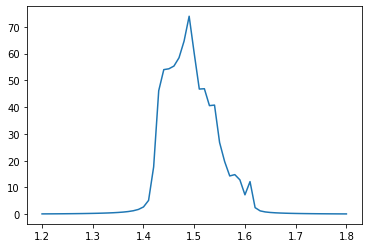

In [295]:
# jdos cv for the random sampling
jdos_cv = U.Dos()
jdos_cv.append_fromPwData(t_cv,w,minVal=1.2,maxVal=1.8,eta=0.004)
jdos_cv.plot(plt)

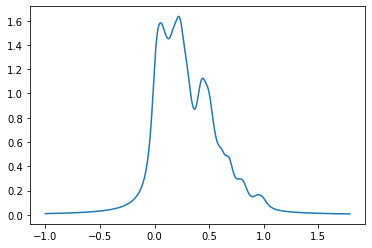

In [296]:
# jdos ccp for the random sampling
jdos_cv = U.Dos()
jdos_cv.append_fromPwData(t_ccp,w,minVal=-1,maxVal=1.8,eta=0.05)
jdos_cv.plot(plt)